## Capstone Project: Quality and Quantity of Grocery Options by Zip Code in Wake County, NC
### Applied Data Science Capstone by Jon Puryear

### Table of Contents

#### Introduction / Business Problem

Wake County, NC is one of the fastest growing areas in the United States. However, there has been concern about access to grocery options in some parts of the county. Some parts of the county have been called a "Food Desert". a Food Desert is an urban area where it is difficuly to buy affordable food ro good-quality fresh food.

### Data Ingestion

#### Notebook Set-up

importing Python Modules needed to process the data for this business analysis

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # converts an address into Latitude and Longitude values
import folium # Map Rendering Library
import requests # Library to handle reqeuests
from sklearn.cluster import KMeans # Clustering Model
import matplotlib as plt
from matplotlib import cm
import matplotlib.colors as colors

setting up Pandas to display all columns instead of truncating them

In [2]:
pd.options.display.max_columns = None

#### Foursquare Data

**FourSquare API Credentials**

In [3]:
CLIENT_ID = 'NIEVOX2VOPTLZY5A5BOIDA2552ZLQAO4XEQV0TLC3SZJCUKL' # your Foursquare ID
CLIENT_SECRET = 'K55CAS1SXXUCJYTJIBXOHN0LKF3BSQETTAN43VMU5A4303G1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NIEVOX2VOPTLZY5A5BOIDA2552ZLQAO4XEQV0TLC3SZJCUKL
CLIENT_SECRET:K55CAS1SXXUCJYTJIBXOHN0LKF3BSQETTAN43VMU5A4303G1


#### IRS Tax Return Data

Data has been sourced from: IRS Information: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi

In [4]:
irs_tax_data = pd.read_excel(r'2017_nc_irs_data.xlsx')

IRS Data is pretty dirty, we only need the Zip Code level aggregate data and the Total Income Column.
The headers that we want to use are on row index [2] and the total income columns is 'Unnamed: 19'

The Zip Code aggregates have a Null value in Column[1], so we will fill that null value with the value 'zip_code_total'

In [5]:
# Replace the existing headers with the new headers from row 2

In [6]:
new_header = irs_tax_data.loc[2]

In [7]:
# Start the dataset at index 3

In [8]:
clean_irs_data = irs_tax_data[3:]

In [9]:
# Add in the new_headers from row 3

In [10]:
clean_irs_data.columns = new_header

In [11]:
# We want Total Income and Number of returns

In [12]:
# Total Income is a NaN field to the right of the count of returns called 'Total Income'

In [13]:
income_index = clean_irs_data.columns.get_loc('Total income')

In [14]:
cols = [clean_irs_data[:2], clean_irs_data[income_index:income_index+2]]

In [15]:
clean_irs_data = clean_irs_data.iloc[:, [0,1,income_index, income_index +1]]

In [16]:
clean_irs_data.columns = ['ZIPCODE', 'gross_income', 'returns_count', 'total_income']

In [17]:
clean_irs_data.fillna(value = 'zip_total', inplace = True)

In [18]:
clean_irs_data = clean_irs_data.loc[clean_irs_data['ZIPCODE'] != 'zip_total']

In [19]:
clean_irs_data = clean_irs_data.loc[clean_irs_data['gross_income'] == 'zip_total']

In [20]:
clean_irs_data.reset_index(inplace = True)

In [21]:
clean_irs_data.drop(columns = ['index'], inplace = True)

In [22]:
clean_irs_data.head()

,ZIPCODE,gross_income,returns_count,total_income
0,27006,zip_total,6900,723443
1,27007,zip_total,900,44445
2,27009,zip_total,1320,108203
3,27011,zip_total,2340,108120
4,27012,zip_total,13550,1209830


We no longer need 'gross_income' so dropping it from the dataset

In [23]:
clean_irs_data.drop(columns = ['gross_income'], inplace = True)

per the IRS Dataset, the total_income value is in Thousands, so we will convert it to regular dollars by * 1000

In [24]:
clean_irs_data['total_income'] = (clean_irs_data['total_income'] * 1000)

#### Wake County Zip Codes

Wake County Zip Codes will be sourced from Zillow.com, which is a real estate site, and confirmed against official Wake County publications (which are ony available in Image Formats). This will be used to determine the Zip Code scope of the Analysis

Wake County Zip Codes: http://data-wake.opendata.arcgis.com/datasets/zip-codes/data

GeoService: https://maps.wakegov.com/arcgis/rest/services/Boundaries/ZipCodes/MapServer/0/query?outFields=*&where=1%3D1

In [25]:
wake_county_zip_codes = pd.read_csv(r'Zip_Codes.csv')

In [26]:
wake_county_zip_codes.head()

,OBJECTID,ZIPNAME,ZIPNUM,ZIPCODE,NAME,SHAPEAREA,SHAPELEN,LAST_EDITED_DATE
0,4927,RALEIGH,27601.0,RALEIGH 27601,RALEIGH,5.075530e+07,43034.538745,NaN
1,4928,DURHAM,27713.0,DURHAM 27713,DURHAM,9.440600e+06,22633.644539,NaN
2,5185,RALEIGH,27604.0,RALEIGH 27604,RALEIGH,5.678501e+08,201307.097948,NaN
3,5186,WAKE FOREST,27587.0,WAKE FOREST 27587,WAKE FOREST,2.682834e+09,561415.191124,2017/10/25 15:38:04+00
4,5187,DURHAM,27703.0,DURHAM 27703,DURHAM,5.768992e+06,22448.009933,NaN


We need to filter of the places where the zipname = 'DURHAM'. Even though some small parts of Durham are in Wake County, the majority of the city is outside the county, and therefore outside the scope of this analysis

In [27]:
## Filter our DURHAM City Data

#### Geographical Data for Zip Codes

Zip Code Data: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html

In [28]:
zip_code_geo_data = pd.read_csv(r'2019_Gaz_zcta_national.txt', delimiter = '\t')

In [29]:
zip_code_geo_data

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,601,166659747,799292,64.348,0.309,18.180555,-66.749961
1,602,79307534,4428428,30.621,1.710,18.361945,-67.175597
2,603,81887188,181412,31.617,0.070,18.455183,-67.119887
3,606,109579993,12487,42.309,0.005,18.158327,-66.932928
4,610,93013428,4172059,35.913,1.611,18.294032,-67.127156
...,...,...,...,...,...,...,...
33139,99923,42162326,2117,16.279,0.001,56.000518,-130.037474
33140,99925,144071036,34333408,55.626,13.256,55.550203,-132.945947
33141,99926,343944587,292859014,132.798,113.074,55.138352,-131.470425
33142,99927,589690080,18001568,227.681,6.950,56.239062,-133.457924


In [30]:
# Rename GeoID to Zip Code?

### Common Dataset for Wake County

We want to build a single dataset from the three we have imported. Datset should be Zip Code, Lat, Long, Total Income, Returns Filed

We will start with the wake_county_zip_codes dataset since it is already limited to the level they is needed for this analysis (Zip Codes in Wake Count)

**Build Base Dataset**

In [31]:
wake_county_dataset = wake_county_zip_codes

In [32]:
## Identify the Columnes that we do not need

In [33]:
drop_cols = {'OBJECTID','ZIPCODE', 'NAME', 'SHAPEAREA','SHAPELEN', 'LAST_EDITED_DATE'}

In [34]:
## Drop the columns we do not need

In [35]:
wake_county_dataset.drop(columns = drop_cols, inplace = True)

In [36]:
# Convert the ZIPNUM from a Float to an Int

In [37]:
### Check for Null Values in the Zip Codes

In [38]:
wake_county_dataset[wake_county_dataset.isna().any(axis = 1)]

,ZIPNAME,ZIPNUM
42,NaN,NaN
43,NaN,NaN
44,NaN,NaN
45,NaN,NaN
46,NaN,NaN
47,NaN,NaN
48,NaN,NaN
49,NaN,NaN
50,NaN,NaN
51,NaN,NaN


In [39]:
### Drop the Null Values from the Dataset

In [40]:
wake_county_dataset.dropna(inplace = True)

In [41]:
## create a new columnd with the Zipcode as an int

In [42]:
wake_county_dataset['ZIPCODE'] = wake_county_dataset['ZIPNUM'].astype(int)

In [43]:
## Drop the Floar column

In [44]:
wake_county_dataset.drop(columns = ['ZIPNUM'], inplace = True)

**Add in Location Information**

In [45]:
## Add a ZIPCODE GEOID field for Merging

In [46]:
zip_code_geo_data['ZIPCODE'] = zip_code_geo_data['GEOID']

In [47]:
wake_county_dataset = pd.merge(wake_county_dataset, zip_code_geo_data, on = 'ZIPCODE', how = 'left')

In [48]:
## Identify the Columnes that we do not need

In [49]:
drop_cols = {'GEOID','ALAND', 'AWATER', 'ALAND_SQMI','AWATER_SQMI'}

In [50]:
## Drop the columns we do not need

In [51]:
wake_county_dataset.drop(columns = drop_cols, inplace = True)

In [52]:
wake_county_dataset.head()

,ZIPNAME,ZIPCODE,INTPTLAT,INTPTLONG
0,RALEIGH,27601,35.773630,-78.634458
1,DURHAM,27713,35.895040,-78.923747
2,RALEIGH,27604,35.822921,-78.562045
3,WAKE FOREST,27587,35.981382,-78.557584
4,DURHAM,27703,35.959272,-78.806808


In [53]:
## Rename The Latitude & Longitude COlumns

In [54]:
wake_county_dataset.columns = ['ZIPNAME', 'ZIPCODE', 'LAT', 'LON']

In [55]:
wake_county_dataset.shape

(55, 4)

In [56]:
len(wake_county_dataset['ZIPCODE'].unique())

39

In [57]:
wake_county_dataset = wake_county_dataset.drop_duplicates()

In [58]:
wake_county_dataset['Neighborhood'] = wake_county_dataset['ZIPNAME'] + ' - ' + wake_county_dataset['ZIPCODE'].astype(str)

In [59]:
## Need to add in Income Information next

#### Visualze the Zip Code centroids

**Use the geopy library to get the latitude and longitude values of Raleigh, NC**

in order to define an instance of the geocode, we need to define a user_agent. The agent will be named *nc_explore*

In [60]:
address = 'Wake County, NC'

geolocator = Nominatim(user_agent = 'nc_explore')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of {} are {}, {}'.format(address, latitude, longitude))

The geographical coordinates of Wake County, NC are 35.7979355, -78.6118311


**Create a Map of Wake County with the Zip Codes superimposed on it**

Create the initial map instance

In [61]:
map_wake = folium.Map(location = [latitude, longitude], zoom_start = 11)

Add markers to the map for each neighborhood

In [62]:
for lat, lng, label in zip(wake_county_dataset['LAT'], wake_county_dataset['LON'], wake_county_dataset['ZIPNAME'] + ' - ' + wake_county_dataset['ZIPCODE'].astype(str)):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_wake)

Display the resultant map

In [63]:
#map_wake

#### Pulling in Grocery Data from Foursquare API



In [64]:
## Define Function

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius = 8047):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
## Run on the Wake County Datset

In [67]:
names = wake_county_dataset['ZIPNAME'] + ' - ' + wake_county_dataset['ZIPCODE'].astype(str)
latitudes = wake_county_dataset['LAT']
longitudes = wake_county_dataset['LON']

In [68]:
wake_venues = getNearbyVenues(names, latitudes, longitudes)

RALEIGH - 27601
DURHAM - 27713
RALEIGH - 27604
WAKE FOREST - 27587
DURHAM - 27703
ROLESVILLE - 27571
KNIGHTDALE - 27545
RALEIGH - 27603
CREEDMOOR - 27522
YOUNGSVILLE - 27596
RALEIGH - 27615
RALEIGH - 27616
RALEIGH - 27612
WENDELL - 27591
RALEIGH - 27609
RALEIGH - 27605
APEX - 27502
GARNER - 27529
RALEIGH - 27608
RALEIGH - 27610
CLAYTON - 27520
ANGIER - 27501
RALEIGH - 27613
RALEIGH - 27614
CARY - 27518
APEX - 27523
RALEIGH - 27617
ZEBULON - 27597
CARY - 27511
CARY - 27519
CARY - 27513
RALEIGH - 27607
RALEIGH - 27606
MORRISVILLE - 27560
APEX - 27539
FUQUAY VARINA - 27526
NEW HILL - 27562
WILLOW SPRING - 27592
HOLLY SPRINGS - 27540


In [69]:
wake_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,RALEIGH - 27601,35.77363,-78.634458,Artspace Visual Arts Center,35.775576,-78.636335,Art Gallery
1,RALEIGH - 27601,35.77363,-78.634458,Burial Beer Co.,35.775241,-78.632247,Brewery
2,RALEIGH - 27601,35.77363,-78.634458,Bida Manda Laotian Restaurant and Bar,35.777227,-78.636812,Asian Restaurant
3,RALEIGH - 27601,35.77363,-78.634458,Duke Energy Center For The Performing Arts,35.771314,-78.639560,Performing Arts Venue
4,RALEIGH - 27601,35.77363,-78.634458,Beasley's Chicken + Honey,35.776968,-78.638175,Southern / Soul Food Restaurant


In [70]:
#Determine the number of unique venues

In [71]:
print('There are {} unique Venue Categories'.format(len(wake_venues['Venue Category'].unique())))

There are 223 unique Venue Categories


In [72]:
print('There are {} unique Venues'.format(len(wake_venues['Venue'].unique())))

There are 1249 unique Venues


In [73]:
# Need to filter out the non-Grocery ones

In [74]:
wake_venues['Venue Category'].unique

<bound method Series.unique of 0                           Art Gallery
1                               Brewery
2                      Asian Restaurant
3                 Performing Arts Venue
4       Southern / Soul Food Restaurant
                     ...               
3327                     Ice Cream Shop
3328                        Video Store
3329                 Salon / Barbershop
3330                       Burger Joint
3331                     Sandwich Place
Name: Venue Category, Length: 3332, dtype: object>

In [75]:
wake_venues.shape

(3332, 7)

In [76]:
wake_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ANGIER - 27501,27,27,27,27,27,27
APEX - 27502,87,87,87,87,87,87
APEX - 27523,73,73,73,73,73,73
APEX - 27539,100,100,100,100,100,100
CARY - 27511,100,100,100,100,100,100


In [77]:
wake_grocery_venues = wake_venues.loc[(wake_venues['Venue Category'] == 'Grocery Store') | (wake_venues['Venue Category'] == 'Organic Grocery') | (wake_venues['Venue Category'] == 'Supermarket')]

In [78]:
wake_grocery_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
83,RALEIGH - 27601,35.773630,-78.634458,The Fresh Market,35.789598,-78.658642,Grocery Store
153,DURHAM - 27713,35.895040,-78.923747,Harris Teeter,35.912543,-78.936125,Supermarket
184,DURHAM - 27713,35.895040,-78.923747,Harris Teeter,35.918031,-78.958794,Supermarket
214,RALEIGH - 27604,35.822921,-78.562045,Trader Joe's,35.823443,-78.621513,Grocery Store
218,RALEIGH - 27604,35.822921,-78.562045,Wegmans,35.820860,-78.620792,Grocery Store


In [79]:
wake_onehot = pd.get_dummies(wake_grocery_venues[['Venue Category']], prefix = '', prefix_sep = '')

In [80]:
wake_onehot['Neighborhood'] = wake_grocery_venues['Neighborhood']

In [81]:
nh_index = wake_onehot.columns.get_loc('Neighborhood')

In [82]:
cols = [wake_onehot.columns[nh_index]] + list(wake_onehot.columns[:nh_index]) + list(wake_onehot.columns[nh_index + 1:])

In [83]:
wake_onehot = wake_onehot[cols]

In [84]:
wake_onehot.head()

,Neighborhood,Grocery Store,Supermarket
83,RALEIGH - 27601,1,0
153,DURHAM - 27713,0,1
184,DURHAM - 27713,0,1
214,RALEIGH - 27604,1,0
218,RALEIGH - 27604,1,0


In [85]:
wake_onehot.shape

(151, 3)

In [86]:
wake_group = wake_onehot.groupby('Neighborhood').sum().reset_index()

In [87]:
wake_group.head()

,Neighborhood,Grocery Store,Supermarket
0,ANGIER - 27501,2,0
1,APEX - 27502,1,3
2,APEX - 27523,3,1
3,APEX - 27539,4,1
4,CARY - 27511,3,2


In [88]:
wake_group.shape

(38, 3)

In [89]:
kclusters = 5

wake_cluster = wake_group.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(wake_cluster)
kmeans.labels_[0:10]

array([2, 3, 2, 1, 2, 4, 3, 4, 0, 0], dtype=int32)

In [90]:
wake_group.insert(0, 'Cluster Labels', kmeans.labels_)

In [91]:
wake_group.head()

,Cluster Labels,Neighborhood,Grocery Store,Supermarket
0,2,ANGIER - 27501,2,0
1,3,APEX - 27502,1,3
2,2,APEX - 27523,3,1
3,1,APEX - 27539,4,1
4,2,CARY - 27511,3,2


In [92]:
wake_merged = wake_county_dataset
wake_merged = wake_merged.join(wake_group.set_index('Neighborhood'), on = 'Neighborhood')

In [93]:
wake_merged.fillna(value = 0, inplace = True)

In [94]:
wake_merged['food_store_count'] = wake_merged['Grocery Store'] + wake_merged['Supermarket']

In [95]:
wake_merged.loc[wake_merged['Cluster Labels'] == 2]

,ZIPNAME,ZIPCODE,LAT,LON,Neighborhood,Cluster Labels,Grocery Store,Supermarket,food_store_count
6,KNIGHTDALE,27545,35.783500,-78.478140,KNIGHTDALE - 27545,2.0,2.0,1.0,3.0
11,YOUNGSVILLE,27596,35.999650,-78.434962,YOUNGSVILLE - 27596,2.0,2.0,1.0,3.0
12,RALEIGH,27615,35.898500,-78.635485,RALEIGH - 27615,2.0,3.0,2.0,5.0
17,RALEIGH,27609,35.843765,-78.633643,RALEIGH - 27609,2.0,3.0,2.0,5.0
23,RALEIGH,27610,35.744400,-78.546278,RALEIGH - 27610,2.0,3.0,1.0,4.0
25,ANGIER,27501,35.484941,-78.684570,ANGIER - 27501,2.0,2.0,0.0,2.0
27,RALEIGH,27614,35.945930,-78.619494,RALEIGH - 27614,2.0,2.0,2.0,4.0
29,APEX,27523,35.773618,-78.956926,APEX - 27523,2.0,3.0,1.0,4.0
32,CARY,27511,35.763313,-78.787832,CARY - 27511,2.0,3.0,2.0,5.0
37,MORRISVILLE,27560,35.857875,-78.827658,MORRISVILLE - 27560,2.0,3.0,2.0,5.0


Bring in the IRS Income and Household Count information

In [96]:
wake_merged = wake_merged.join(clean_irs_data.set_index('ZIPCODE'), on = 'ZIPCODE', how = 'left')

In [97]:
wake_merged.head()

,ZIPNAME,ZIPCODE,LAT,LON,Neighborhood,Cluster Labels,Grocery Store,Supermarket,food_store_count,returns_count,total_income
0,RALEIGH,27601,35.773630,-78.634458,RALEIGH - 27601,0.0,1.0,0.0,1.0,4340,289082000
1,DURHAM,27713,35.895040,-78.923747,DURHAM - 27713,0.0,0.0,2.0,2.0,26260,1989180000
2,RALEIGH,27604,35.822921,-78.562045,RALEIGH - 27604,1.0,4.0,0.0,4.0,21720,1130719000
3,WAKE FOREST,27587,35.981382,-78.557584,WAKE FOREST - 27587,3.0,4.0,3.0,7.0,30920,2993556000
4,DURHAM,27703,35.959272,-78.806808,DURHAM - 27703,0.0,0.0,2.0,2.0,27620,1576820000


Calculate the average reported Income per Household

In [98]:
wake_merged['income_per_household'] = (wake_merged['total_income'] / wake_merged['returns_count'] )

Calculate the average # of Households that each food store serves

In [99]:
wake_merged.reset_index(inplace = True)

In [100]:
wake_merged['households_served'] = 0

In [101]:
for i in range(len(wake_merged)):
    if wake_merged.loc[i, 'food_store_count'] == 0:
        wake_merged.loc[i, 'households_served'] = 0
    else:
        wake_merged.loc[i, 'households_served'] = (wake_merged.loc[i, 'returns_count'] / wake_merged.loc[i, 'food_store_count'].astype(int))

<AxesSubplot:xlabel='households_served', ylabel='income_per_household'>

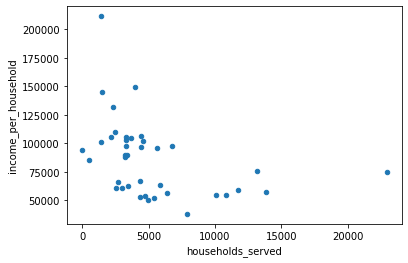

In [102]:
wake_merged.plot.scatter(x = 'households_served', y = 'income_per_household') 

In [103]:
wake_merged.describe()

,index,LAT,LON,Cluster Labels,Grocery Store,Supermarket,food_store_count,households_served
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,22.282051,35.793135,-78.683405,1.487179,2.102564,1.769231,3.871795,5210.567081
std,13.412384,0.133357,0.162018,1.315331,1.651074,1.286806,2.341609,4375.824112
min,0.000000,35.484941,-78.990017,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.500000,35.725385,-78.804690,0.000000,1.000000,1.000000,2.000000,2859.166667
50%,23.000000,35.801980,-78.675202,2.000000,2.000000,2.000000,4.000000,4005.000000
75%,32.500000,35.880777,-78.574269,2.500000,3.000000,2.500000,5.000000,5754.166667
max,47.000000,36.105618,-78.303150,4.000000,7.000000,5.000000,11.000000,22920.000000


In [104]:
wake_merged

,index,ZIPNAME,ZIPCODE,LAT,LON,Neighborhood,Cluster Labels,Grocery Store,Supermarket,food_store_count,returns_count,total_income,income_per_household,households_served
0,0,RALEIGH,27601,35.773630,-78.634458,RALEIGH - 27601,0.0,1.0,0.0,1.0,4340,289082000,66608.8,4340.000000
1,1,DURHAM,27713,35.895040,-78.923747,DURHAM - 27713,0.0,0.0,2.0,2.0,26260,1989180000,75749.4,13130.000000
2,2,RALEIGH,27604,35.822921,-78.562045,RALEIGH - 27604,1.0,4.0,0.0,4.0,21720,1130719000,52058.9,5430.000000
3,3,WAKE FOREST,27587,35.981382,-78.557584,WAKE FOREST - 27587,3.0,4.0,3.0,7.0,30920,2993556000,96816.2,4417.142857
4,4,DURHAM,27703,35.959272,-78.806808,DURHAM - 27703,0.0,0.0,2.0,2.0,27620,1576820000,57089.8,13810.000000
5,5,ROLESVILLE,27571,35.919490,-78.458036,ROLESVILLE - 27571,3.0,3.0,4.0,7.0,3370,289268000,85836.2,481.428571
6,6,KNIGHTDALE,27545,35.783500,-78.478140,KNIGHTDALE - 27545,2.0,2.0,1.0,3.0,14210,765208000,53850,4736.666667
7,8,RALEIGH,27603,35.664637,-78.652498,RALEIGH - 27603,3.0,1.0,3.0,4.0,23580,1504774000,63815.7,5895.000000
8,10,CREEDMOOR,27522,36.105618,-78.675202,CREEDMOOR - 27522,0.0,0.0,2.0,2.0,5990,364861000,60911.7,2995.000000
9,11,YOUNGSVILLE,27596,35.999650,-78.434962,YOUNGSVILLE - 27596,2.0,2.0,1.0,3.0,8170,538053000,65857.2,2723.333333


In [105]:
#wake_cluster_avg = wake_merged.groupby('Cluster Labels').mean()

In [106]:
#wake_cluster_avg

In [107]:
# create map

map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x)**2 for i in range(kclusters)]
cmap = cm.get_cmap('rainbow')
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cmap(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(wake_merged['LAT'], wake_merged['LON'], wake_merged['Neighborhood'], wake_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster) - 1],
        fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters